In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("diabetes.csv")

In [5]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
Pedigree,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [7]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

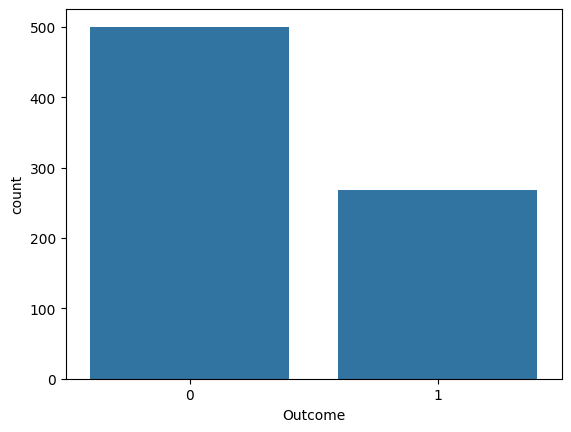

In [8]:
sns.countplot(data=df, x=df["Outcome"])
plt.show()

In [9]:
negative_data = df[df["Outcome"] == 0]
positive_data = df[df["Outcome"] == 1] 

In [10]:
positive_upsample = resample(
    positive_data,
    replace=True,
    n_samples=int(0.9 * len(negative_data)),
    random_state=42,
)

In [12]:
new_df = negative_data
new_df = pd.concat([new_df, positive_upsample], ignore_index=True)

In [13]:
new_df.shape

(950, 9)

In [14]:
new_df = new_df.sample(frac=1)

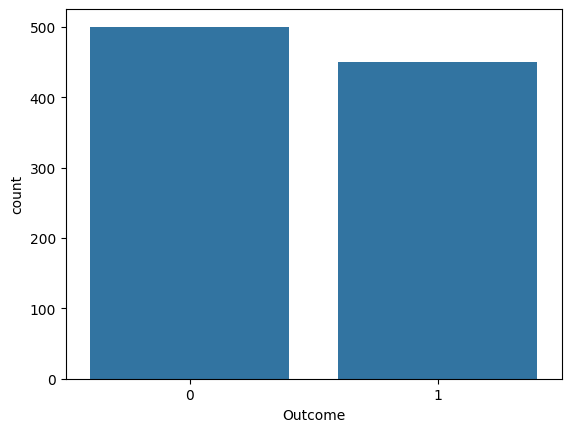

In [15]:
sns.countplot(data=new_df, x=new_df["Outcome"])
plt.show()

In [18]:
x = new_df.drop("Outcome", axis=1)
y = new_df[["Outcome"]]

In [19]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(x)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    scaled_values, y, test_size=0.2, random_state=42
)

In [22]:
k_values = [1, 3, 5, 7, 9,  11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37,  39, 41, 43, 45, 47, 49]
accuracy_values = []

In [23]:
for i in tqdm(range(len(k_values))):
    model = KNeighborsClassifier(n_neighbors=k_values[i])
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracy_values.append(accuracy)

  0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
px.line(x=k_values, y=accuracy_values)

In [25]:
optimal_k = -1
optimal_accuracy = -1
for i in list(zip(k_values, accuracy_values)):
    if i[1] > optimal_accuracy:
        optimal_k = i[0]
        optimal_accuracy = i[1]

In [26]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)

In [27]:
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [28]:
y_pred = knn_model.predict(x_test)

In [29]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85        94
           1       0.85      0.86      0.86        96

    accuracy                           0.85       190
   macro avg       0.85      0.85      0.85       190
weighted avg       0.85      0.85      0.85       190



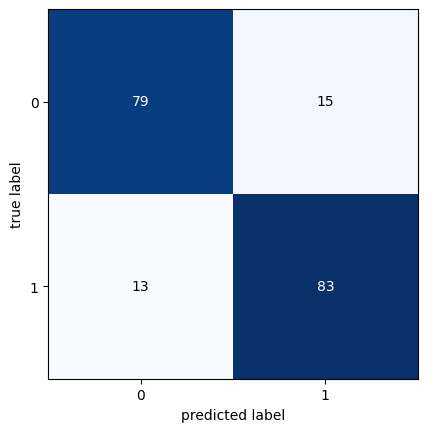

In [30]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)
plt.show()

In [31]:
y_score = model.predict_proba(x_test)[:, 1]

In [32]:
false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(y_test, y_score)

In [33]:
print("roc_auc_score for DecisionTree: ", metrics.roc_auc_score(y_test, y_score))

roc_auc_score for DecisionTree:  0.8195367907801419


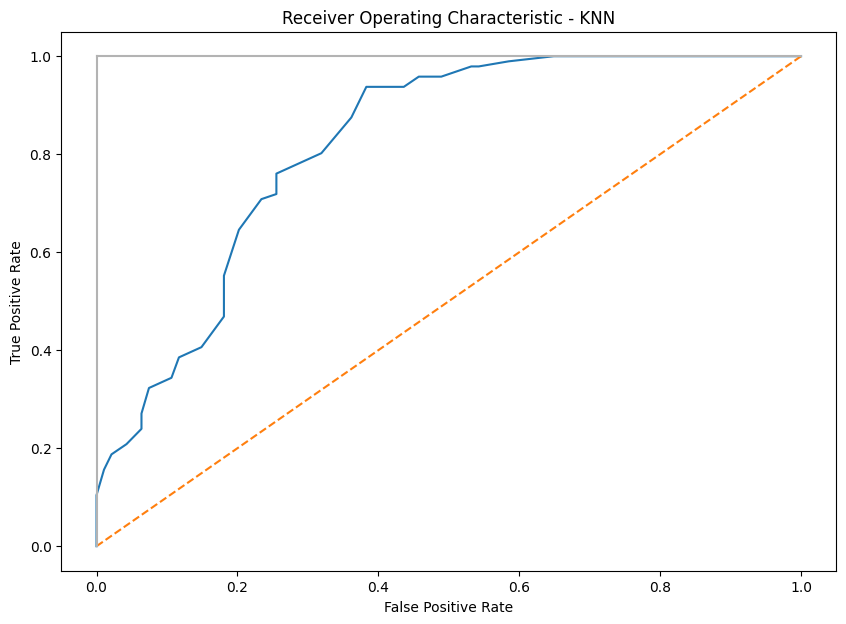

In [34]:
plt.subplots(1, figsize=(10, 7))
plt.title("Receiver Operating Characteristic - KNN")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()